In [ ]:
#IMPORT ALL NECESSARY LIBRARIES NEEDED
import collections
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
#LOADING IN AND OPENING THE FILE 
def load_data(input_file):
   
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [ ]:
#THE SAMPLE ENGLISH AND FRENCH FILES ARE LOADED IN .CSV FORMAT
english_sentences = load_data('/content/small_vocab_en.csv')
french_sentences = load_data('/content/small_vocab_fr.csv')

In [ ]:
english_sentences

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .',
 'his favorite fruit is the orange , but my favorite is the grape .',
 'paris is relaxing during december , but it is usually chilly in july .',
 'new jersey is busy during spring , and it is never hot in march .',
 'our least liked fruit is the lemon , but my least liked is the grape .',
 'the united states is sometimes busy during january , and it is sometimes warm in november .',
 'the lime is her least liked fruit , but the banana is my least liked .',
 'he saw a old yellow truck .',
 'india is rainy during june , and it is sometimes warm in november .',
 'that cat was my most l

In [ ]:
#HERE WE ARE SPLITTING DATA INTO TRAIN/TEST SPLITS
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [ ]:
english_words_counter

Counter({',': 140897,
         '.': 129039,
         '?': 811,
         'a': 1944,
         'am': 24,
         'and': 59850,
         'animal': 2304,
         'animals': 768,
         'apple': 4652,
         'apple.': 196,
         'apples': 5452,
         'apples.': 392,
         'april': 8954,
         'are': 870,
         "aren't": 36,
         'august': 8789,
         'automobile': 1944,
         'autumn': 9004,
         'banana': 4652,
         'banana.': 196,
         'bananas': 5452,
         'bananas.': 392,
         'bear': 192,
         'bears': 64,
         'beautiful': 8915,
         'been': 36,
         'between': 540,
         'big': 1016,
         'bird': 192,
         'birds': 64,
         'black': 972,
         'blue': 972,
         'busy': 8791,
         'but': 63987,
         'california': 11250,
         'car': 1944,
         'cat': 192,
         'cats': 64,
         'chilly': 8770,
         'china': 10953,
         'chinese': 312,
         'cold': 8878,
         'd

In [ ]:
#HERE WE ARE USING FUNCTIONS FOR DATA PREPROCESSING
#First, we will be tokenizing the function to transform
def tokenize(sentence):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(sentence)
    return tokenizer.texts_to_sequences(sentence), tokenizer

In [ ]:
#Introducing the Padding Function
def pad(sentence, length=None):
    if length is None:
        length = max([len(sentence) for sentence in sentence])
    return pad_sequences(sentence, maxlen = length, padding = 'post')

In [ ]:
#Preprocessing the pipeline function
def preprocess(x, y):
    
    # Tokenize the input data
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    
    #Pad the Tokenized data
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [ ]:
#Checking..
tokenize('My name is Sam')

([[1], [5], [2], [6], [3], [1], [7], [2], [8], [4], [2], [4], [3], [1]],
 <keras_preprocessing.text.Tokenizer at 0x7fe40d027050>)

In [ ]:
#TRAIN PREPROCESSING DATA
#Run Preprocessing pipeline on Data
processed_english_sentences, processed_french_sentences, eng_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

#Get train data lengths and sizes
max_english_sequence_length = processed_english_sentences.shape[1]
max_french_sequence_length = processed_french_sentences.shape[1]
english_vocab_size = len(eng_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Train Data Preprocessed')
print('Train data: English vocab size -', len(processed_english_sentences))
print('Train data: French vocab size -', len(processed_french_sentences))
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocab size:", english_vocab_size)
print("French vocab size:", french_vocab_size)

Train Data Preprocessed
Train data: English vocab size - 137861
Train data: French vocab size - 137861
Max English sentence length: 15
Max French sentence length: 21
English vocab size: 199
French vocab size: 344


In [ ]:
# RNN model incorporating Bidirectional and Embedding techniques in Neural network

# Set Model Parameters and layers
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=len(eng_tokenizer.word_index)+1,
                    output_dim=128,
                    input_length=processed_english_sentences.shape[1]))

# 1st Bidrectional layer - no feedback returned
model.add(Bidirectional(GRU(256,return_sequences=False)))
model.add(RepeatVector(processed_french_sentences.shape[1]))

# 2nd Embedding layer - feedback returned
model.add(Bidirectional(GRU(256,return_sequences=True)))
model.add(TimeDistributed(Dense(len(french_tokenizer.word_index)+1,activation='softmax')))
learning_rate = 0.005

# Compile Model parameters
model.compile(loss = sparse_categorical_crossentropy, 
              optimizer = Adam(learning_rate), 
              metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
# Fit Model on Data
model.fit(processed_english_sentences,processed_french_sentences, batch_size = 64, epochs = 100, validation_split = 0.2)

Epoch 1/100
1724/1724 [==============================] - 35s 14ms/step - loss: 0.6141 - accuracy: 0.8309 - val_loss: 0.3811 - val_accuracy: 0.8916
Epoch 2/100
1724/1724 [==============================] - 23s 13ms/step - loss: 0.2885 - accuracy: 0.9135 - val_loss: 0.2795 - val_accuracy: 0.9173
Epoch 3/100
1724/1724 [==============================] - 23s 13ms/step - loss: 0.2707 - accuracy: 0.9186 - val_loss: 0.2595 - val_accuracy: 0.9237
Epoch 4/100
1724/1724 [==============================] - 23s 14ms/step - loss: 0.5944 - accuracy: 0.8273 - val_loss: 0.7174 - val_accuracy: 0.7788
Epoch 5/100
1724/1724 [==============================] - 23s 13ms/step - loss: 0.8241 - accuracy: 0.7483 - val_loss: 0.7659 - val_accuracy: 0.7581
Epoch 6/100
1724/1724 [==============================] - 23s 13ms/step - loss: 1.0556 - accuracy: 0.6982 - val_loss: 1.4713 - val_accuracy: 0.6146
Epoch 7/100
1724/1724 [==============================] - 23s 13ms/step - loss: 1.2514 - accuracy: 0.6470 - val_loss: 1

In [ ]:
# Fit Model on Data
history = model.fit(processed_english_sentences,processed_french_sentences, batch_size = 64, epochs = 50, validation_split = 0.2)

Epoch 1/50
1724/1724 [==============================] - 36s 14ms/step - loss: 0.6256 - accuracy: 0.8264 - val_loss: 0.2990 - val_accuracy: 0.9085
Epoch 2/50
1724/1724 [==============================] - 23s 14ms/step - loss: 0.2663 - accuracy: 0.9196 - val_loss: 0.2514 - val_accuracy: 0.9255
Epoch 3/50
1724/1724 [==============================] - 24s 14ms/step - loss: 0.3481 - accuracy: 0.8958 - val_loss: 0.4841 - val_accuracy: 0.8554
Epoch 4/50
1724/1724 [==============================] - 24s 14ms/step - loss: 0.6310 - accuracy: 0.8158 - val_loss: 1.0371 - val_accuracy: 0.6978
Epoch 5/50
1724/1724 [==============================] - 24s 14ms/step - loss: 0.9649 - accuracy: 0.7141 - val_loss: 1.3906 - val_accuracy: 0.6223
Epoch 6/50
1724/1724 [==============================] - 24s 14ms/step - loss: 1.0515 - accuracy: 0.6860 - val_loss: 0.9900 - val_accuracy: 0.6945
Epoch 7/50
1724/1724 [==============================] - 24s 14ms/step - loss: 0.9604 - accuracy: 0.7025 - val_loss: 0.8554 -

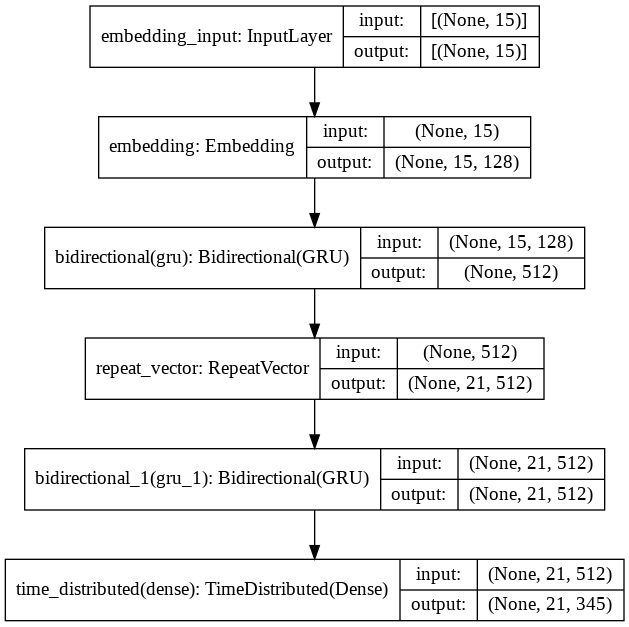

In [ ]:
#from tensorflow.keras.utils.vis_utils import plot_model
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# inbound_layer_id = str(id(inbound_layer))
# if not expand_nested:
#   assert dot.get_node(inbound_layer_id)
#   assert dot.get_node(layer_id)
#   add_edge(dot, inbound_layer_id, layer_id)

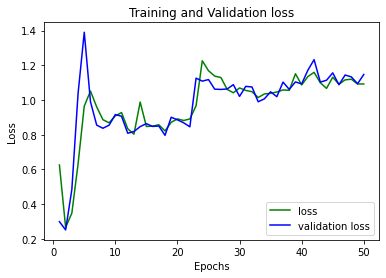

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

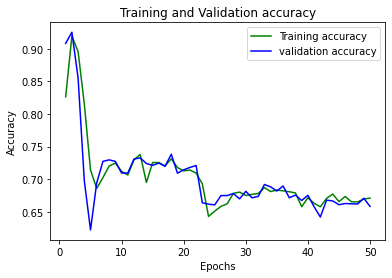

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def English_to_French(sentence):
    
    french_id_to_word = {value: key for key, value in french_tokenizer.word_index.items()}
    french_id_to_word[0] = ''
    x = sentence
    # Get Id's for tokenized sentence
    sentence = [eng_tokenizer.word_index[word] for word in sentence.split()]
    # Pad Id's to uniform length
    sentence = pad_sequences([sentence], maxlen=processed_english_sentences.shape[-1], padding='post')
    # Predict french Id's using sentence Id's in Fitted Model
    predictions = model.predict(sentence, len(sentence))
  
    print(x, "in French:")
    print(' '.join([french_id_to_word[np.argmax(processed_english_sentences)] for processed_english_sentences in predictions[0]]))

In [ ]:
phrase = 'he likes lemon in the summer'
English_to_French(phrase)

he likes lemon in the summer in French:
il aime aller aux unis unis               
